In [1]:
import torch 
import numpy as np 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 

import time 
from dgl.nn import GraphConv 

import networkx as nx

import torch 
from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx

import matplotlib.pyplot as plt 
import warnings

from dgl.data import CoraGraphDataset

warnings.filterwarnings('ignore')
%matplotlib inline

c:\Users\EonKim\anaconda3\envs\dgl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


$\text{Node : }$ 머신러닝 논문

$\text{Edge : }$ 논문 쌍 간의 인용

$\text{Feature : }$ 노드 $\text{Feature}$의 수

$\text{Classes : }$ 논문 라벨링 0~6

In [2]:
# CoraGraphDataset -> citation network.
dataset = CoraGraphDataset()
g = dataset[0]

features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
test_mask = g.ndata['test_mask']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
u, v = g.all_edges()
graph_edge = torch.stack([u, v]).long()
num_nodes = features.shape[0]

In [4]:
graph_edge

tensor([[   3,    5,    6,  ..., 2704, 2707, 2706],
        [   0,    0,    0,  ..., 2705, 2706, 2707]])

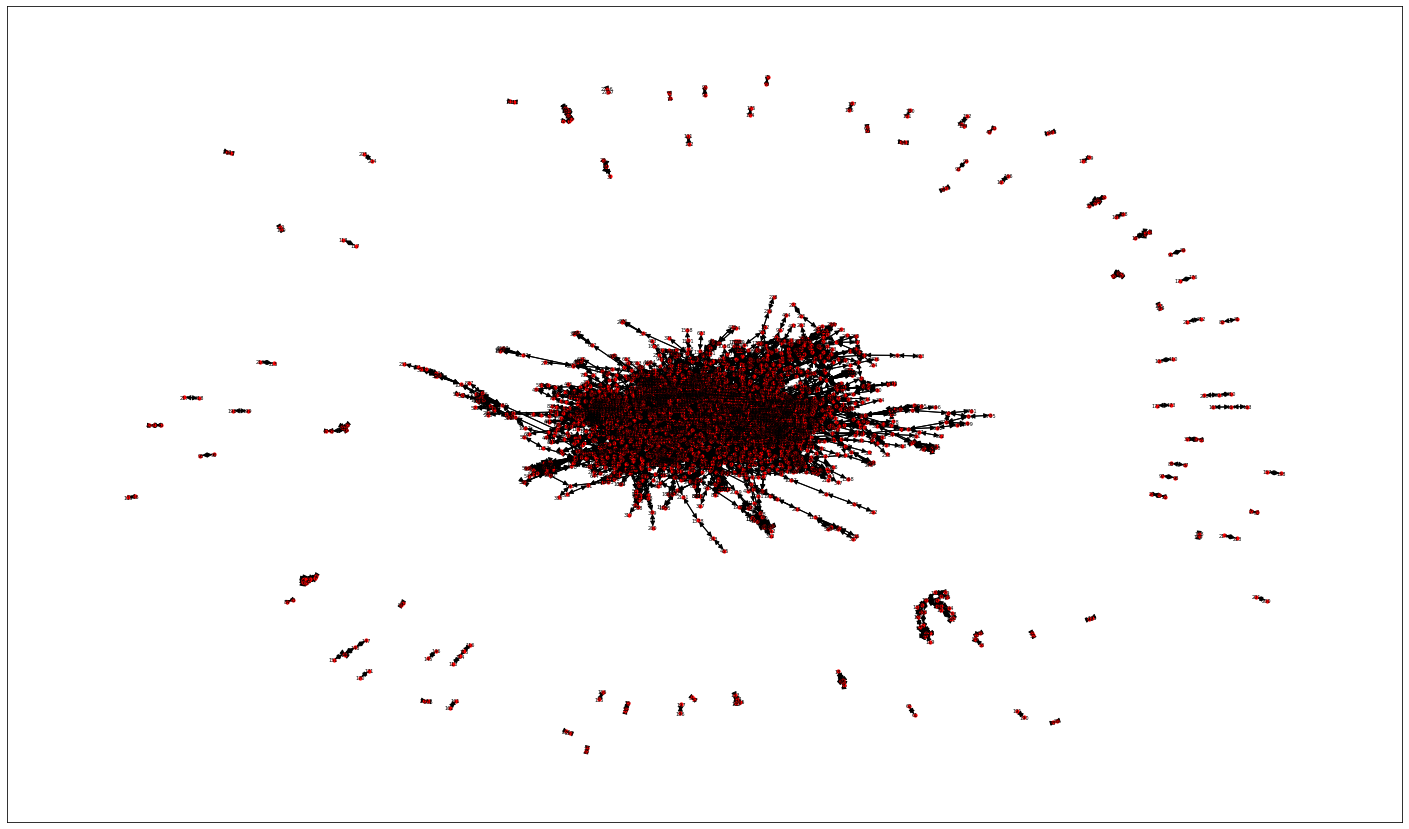

In [111]:
Graph = Data(edge_index = graph_edge, num_nodes=num_nodes)
G = to_networkx(Graph)
fig, axes = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, node_size = 10, node_color='red', font_size=5)

In [104]:
num_features = features.shape[1] # N * F
hidden_dim = 64 
output_dim = 7
num_epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### $$ \tilde{A} = A + I $$
### $$ \tilde{D}_{ii} = \sum_j A_{ij} $$
### $$ \hat{A} = \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} \text{: Laplacian normalization}$$
$ \ $
  
### $$ x_1 = \text{ReLU}(\hat{A} X W^{(0)} + b^{(0)}) $$
### $$ x_2 = ( \hat{A} x_1 W^{(1)} + b^{(1)}) $$
$x_1, x_2$는 각각 첫 번째, 두 번째 Convolution을 의미한다. 

$\text{ReLU}$는 $\text{activation function}$을 의미한다.


![graphconv_pic1](figure/graphconv_pic1.JPG)

In [105]:
class SimpleGraphConv(nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(SimpleGraphConv, self).__init__()
        self.layer1 = GraphConv(num_features, hidden_dim, norm='both') # activation default=None 
        self.layer2 = GraphConv(hidden_dim, output_dim, norm='both') # activation defalut=None
        self.relu = nn.ReLU()
        self._init_weight()
        
    def forward(self, g, features):
        x1 = self.layer1(g, features)
        x1 = self.relu(x1)
        x2 = self.layer2(g, x1)
        return x2
    
    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, GraphConv):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

In [106]:
F.cross_entropy

<function torch.nn.functional.cross_entropy(input: torch.Tensor, target: torch.Tensor, weight: Optional[torch.Tensor] = None, size_average: Optional[bool] = None, ignore_index: int = -100, reduce: Optional[bool] = None, reduction: str = 'mean', label_smoothing: float = 0.0) -> torch.Tensor>

In [107]:
models = SimpleGraphConv(num_features, hidden_dim, output_dim)
optimizer = optim.Adam(models.parameters(), lr = 1e-2)


def calc_accuracy(pred, label, mask):
    pred = pred[mask]
    label = label[mask]
    pred = torch.argmax(pred, dim=-1)
    correct = (pred == label).sum()
    return (correct.item() / len(label)) * 100 

def criterion(pred, label, mask):
    pred = pred[mask]
    label = label[mask]
    return F.cross_entropy(pred, label)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time 
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = elapsed_time - elapsed_mins * 60
    return elapsed_mins, elapsed_secs 

### $$y * \log (\text{softmax}(z)) = \text{cross entropy}$$
### $$\text{cross entropy = log softmax + nll loss}$$
### $$\text{nll loss : Negative Likelihood}$$

In [108]:
# self-connection 
print(f'number of edges, before self-connection :{g.num_edges()}')
g.add_edge(g.nodes(), g.nodes()) # or g.add_self_loop()
print(f'number of edges, after self-connection :{g.num_edges()}')

# GCN을 제안한 논문에서는 Node Classification을 수행할 때 Label된 Node들만 propagation rule을 적용하기 때문에 labeling된 loss 값만 가지고 back-propagation을 수행한다. 

number of edges, before self-connection :10556
number of edges, after self-connection :13264


In [109]:
train_loss_list = []
train_acc_list = []

test_loss_list = []
test_acc_list = []

for epoch in range(1,num_epochs+1):
    start_time = time.time()
    models.train()
    optimizer.zero_grad()
    pred = models(g, features)
    loss = criterion(pred, labels, train_mask) # 둘 중 하나 아무거나 사용해도 무방.
#   logp = F.log_softmax(pred, dim=-1)
#   loss = F.nll_loss(logp[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()
    
    train_loss = loss.detach().item()
    train_acc = calc_accuracy(pred, labels, train_mask)
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    
    
    models.eval()
    with torch.no_grad():
        pred = models(g, features)
        test_loss = criterion(pred, labels, test_mask)
        test_acc = calc_accuracy(pred, labels, test_mask)
        
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        if (epoch) % 20 == 0 :
            print(f'epoch [{epoch}/{num_epochs}] | Epoch time : {epoch_mins}m, {epoch_secs*20:.2f}s \n train loss: {train_loss:.4f}\t train acc: {train_acc:.2f}%')
            print(f' test loss: {test_loss:.4f}\t test acc: {test_acc:.2f}% \n')

epoch [20/200] | Epoch time : 0m, 0.89s 
 train loss: 1.0982	 train acc: 98.57%
 test loss: 1.4286	 test acc: 79.20% 

epoch [40/200] | Epoch time : 0m, 1.12s 
 train loss: 0.2061	 train acc: 99.29%
 test loss: 0.7642	 test acc: 81.20% 

epoch [60/200] | Epoch time : 0m, 0.84s 
 train loss: 0.0449	 train acc: 100.00%
 test loss: 0.6526	 test acc: 80.40% 

epoch [80/200] | Epoch time : 0m, 0.86s 
 train loss: 0.0187	 train acc: 100.00%
 test loss: 0.6533	 test acc: 79.70% 

epoch [100/200] | Epoch time : 0m, 0.88s 
 train loss: 0.0112	 train acc: 100.00%
 test loss: 0.6607	 test acc: 79.30% 

epoch [120/200] | Epoch time : 0m, 0.82s 
 train loss: 0.0078	 train acc: 100.00%
 test loss: 0.6688	 test acc: 79.40% 

epoch [140/200] | Epoch time : 0m, 0.86s 
 train loss: 0.0059	 train acc: 100.00%
 test loss: 0.6777	 test acc: 79.20% 

epoch [160/200] | Epoch time : 0m, 0.91s 
 train loss: 0.0046	 train acc: 100.00%
 test loss: 0.6863	 test acc: 78.60% 

epoch [180/200] | Epoch time : 0m, 0.8

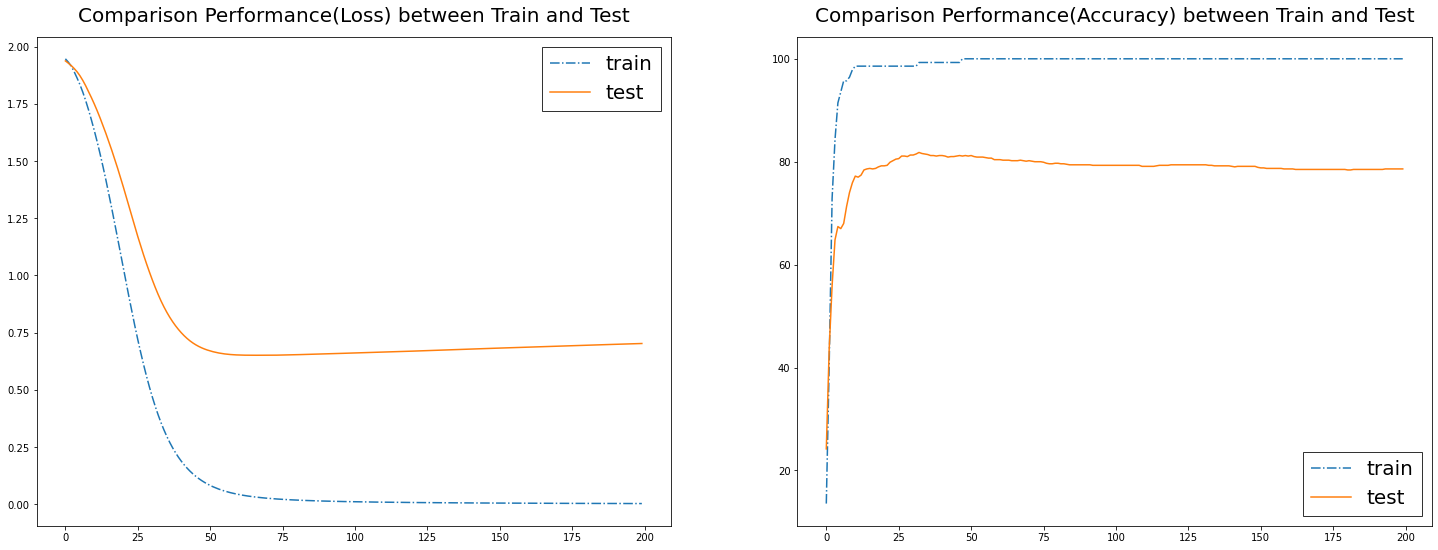

In [110]:
k = np.arange(num_epochs)
results = dict({
    'train':[train_loss_list, train_acc_list], 
    'test':[test_loss_list, test_acc_list]
})

fig, aes = plt.subplots(nrows=1,ncols=2, figsize = (25, 9))
for i, ax in enumerate(aes):
    ax.plot(k, results['train'][i], linestyle='-.', label='train')
    ax.plot(k, results['test'][i], linestyle='-', label='test')
    ax.legend(fontsize=20, fancybox=False, edgecolor='black')
    if i == 0:
        ax.set_title('Comparison Performance(Loss) between Train and Test', size=20, pad=15)
    else:
        ax.set_title('Comparison Performance(Accuracy) between Train and Test', size=20, pad=15)
    